In [1]:
import pandas as pd

df = pd.read_csv("data/data.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
df_clean = df.copy(deep=True)
df_clean = df_clean.drop(columns=["isFlaggedFraud"])
df_clean["nameOrig"] = df_clean["nameOrig"].str[0]
df_clean["nameDest"] = df_clean["nameDest"].str[0]

In [3]:
df_clean = pd.get_dummies(df_clean)

In [4]:
from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=["isFraud"])
y = df_clean["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [5]:
from xgboost import XGBClassifier

model = XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        eval_metric='aucpr',
        random_state=42
)

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3,5,7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
}

grid = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=5,
    verbose=2
)

In [7]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   3.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   3.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   3.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   3.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   3.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   4.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   4.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   4.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   4.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   4.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   3.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_es

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the 

In [8]:
best_model = grid.best_estimator_

In [9]:
best_model.score(X_test, y_test)

0.9982956706513983

In [10]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.43      0.99      0.60      2053

    accuracy                           1.00   1590655
   macro avg       0.72      0.99      0.80   1590655
weighted avg       1.00      1.00      1.00   1590655



In [12]:
print(confusion_matrix(y_test, y_pred))

[[1585918    2684]
 [     27    2026]]


In [13]:
print(roc_auc_score(y_test, y_pred_proba[:,1]))

0.9997750265158682


In [14]:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

/Users/dbreiding001/Documents/Prep/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


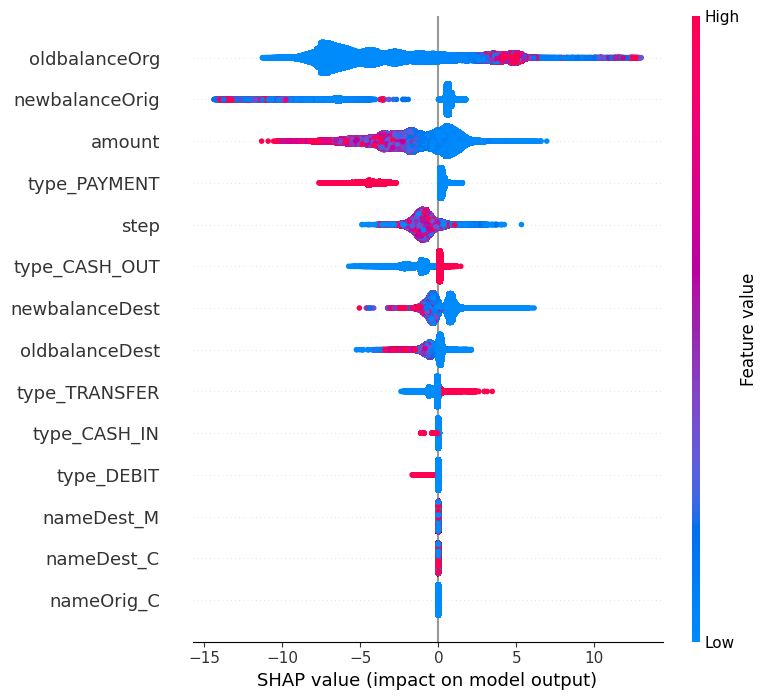

In [15]:
shap.summary_plot(shap_values, X_test)